# Agent Middleware Essentials

Add production-ready middleware for message management, limits, fallbacks, and dynamic prompts.

**What you'll learn:**
- Middleware adds production capabilities without changing agent logic
- Trim messages keeps recent messages within context window
- Delete messages removes specific or all messages from state
- SummarizationMiddleware prevents context overflow with summaries
- TodoListMiddleware provides task planning and tracking
- Limits control costs and API usage
- Fallbacks improve reliability
- Dynamic prompts enable context-aware behavior
- FilesystemFileSearchMiddleware provides file search capabilities

In [1]:
import sys
sys.path.append('../')

import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.agents import create_agent
from langchain.messages import HumanMessage

from scripts import base_tools

from langgraph.checkpoint.memory import InMemorySaver

model = ChatGoogleGenerativeAI(model='gemini-2.5-flash')
checkpointer = InMemorySaver()

## Setup checkpointer with SQLite
# from langgraph.checkpoint.sqlite import SqliteSaver
# import sqlite3
# conn = sqlite3.connect("db/middleware_agent.db", check_same_thread=False)
# checkpointer = SqliteSaver(conn)
# checkpointer.setup()

## Trim Messages

Keep only recent messages to fit context window.

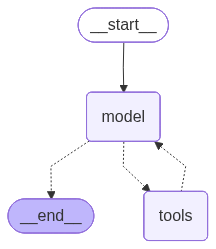

In [ ]:
from langchain.messages import RemoveMessage
from langgraph.graph.message import REMOVE_ALL_MESSAGES

from langchain.agents.middleware import before_model, after_model, before_agent, after_agent
from langgraph.runtime import Runtime

from langchain.agents import AgentState

@before_model
def trim_messages(state: AgentState, runtime: Runtime):
    """Keep only the last few messages to fit context window."""

    messages = state['messages']

    if len(messages)<=3:
        return None
    
    first_msg = messages[0]

    last_msg = messages[-1]

    new_messages = [first_msg, last_msg]

    return {
        'messages': [
            RemoveMessage(id=REMOVE_ALL_MESSAGES),
            *new_messages
        ]
    }

agent = create_agent(
    model=model,
    tools=[base_tools.web_search, base_tools.get_weather],
    checkpointer=checkpointer,
    middleware=[trim_messages]
)

agent


In [9]:
config = {"configurable": {"thread_id": "trim_session"}}

agent.invoke({"messages": "hi, my name is Laxmi Kant"}, config)
agent.invoke({"messages": "write a short poem about cats"}, config)
agent.invoke({"messages": "now do the same but for dogs"}, config)
response = agent.invoke({"messages": "what's my name?"}, config)

In [10]:
response

{'messages': [HumanMessage(content='hi, my name is Laxmi Kant', additional_kwargs={}, response_metadata={}, id='4ea0b15b-edf5-4ff4-8619-6bd8a08e6638'),
  HumanMessage(content="what's my name?", additional_kwargs={}, response_metadata={}, id='3430e56d-0cfb-4e33-81e3-4756e0594b16'),
  AIMessage(content=[{'type': 'text', 'text': 'Your name is Laxmi Kant.', 'extras': {'signature': 'CpoCAXLI2nwnQgMDQ3/QgtQTqxD11EctwmoQNOl4TCfs0c0vluO4h16Eicj6gkKMg+5UH3getFyHzb306XTU+Qw8rk7+bKewbas8WePC6X+Rm4c//glR/r8CVzIdoehCylnFw3xej/pYBnRb97p+nHfVIUj13+sfwfzpc9b4pNwLMgsQGIfaBUMXus09RX5yO14mn5dkshJlVdDfcDWeMhPifyxy7OoSIKIP2rIUxec7pgz0zbiH78YlCPlikesx8fgcOM1IfyBNUFQHPLaLh96VoIqfCmaecaUbiyTsPSTD2w3BU86yKiudEA76I3t9RuN6NNBOq0LXDGJ/J9NAVTYomJQ1obJMn3YuuIEqxZwwfYi9LTJfYj1N+lio'}}], additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019bc79f-8c54-7901-9885-5f7426f8a6eb-0', tool_calls=[], invalid_

In [11]:
agent.invoke({"messages": "what is the weather in Mumbai?"}, config)

{'messages': [HumanMessage(content='hi, my name is Laxmi Kant', additional_kwargs={}, response_metadata={}, id='4ea0b15b-edf5-4ff4-8619-6bd8a08e6638'),
  ToolMessage(content='{"location": {"name": "Mumbai", "region": "Maharashtra", "country": "India", "lat": 18.975, "lon": 72.826, "tz_id": "Asia/Kolkata", "localtime_epoch": 1768580778, "localtime": "2026-01-16 21:56"}, "current": {"last_updated_epoch": 1768580100, "last_updated": "2026-01-16 21:45", "temp_c": 25.4, "temp_f": 77.7, "is_day": 0, "condition": {"text": "Mist", "icon": "//cdn.weatherapi.com/weather/64x64/night/143.png", "code": 1030}, "wind_mph": 9.4, "wind_kph": 15.1, "wind_degree": 346, "wind_dir": "NNW", "pressure_mb": 1014.0, "pressure_in": 29.94, "precip_mm": 0.0, "precip_in": 0.0, "humidity": 74, "cloud": 0, "feelslike_c": 26.7, "feelslike_f": 80.0, "windchill_c": 24.9, "windchill_f": 76.7, "heatindex_c": 26.2, "heatindex_f": 79.1, "dewpoint_c": 17.1, "dewpoint_f": 62.8, "vis_km": 2.1, "vis_miles": 1.0, "uv": 0.0, "gu

In [13]:
agent.invoke({"messages": "what is the weather in Mumbai?"}, config)

{'messages': [HumanMessage(content='hi, my name is Laxmi Kant', additional_kwargs={}, response_metadata={}, id='4ea0b15b-edf5-4ff4-8619-6bd8a08e6638'),
  ToolMessage(content='{"location": {"name": "Mumbai", "region": "Maharashtra", "country": "India", "lat": 18.975, "lon": 72.826, "tz_id": "Asia/Kolkata", "localtime_epoch": 1768580778, "localtime": "2026-01-16 21:56"}, "current": {"last_updated_epoch": 1768580100, "last_updated": "2026-01-16 21:45", "temp_c": 25.4, "temp_f": 77.7, "is_day": 0, "condition": {"text": "Mist", "icon": "//cdn.weatherapi.com/weather/64x64/night/143.png", "code": 1030}, "wind_mph": 9.4, "wind_kph": 15.1, "wind_degree": 346, "wind_dir": "NNW", "pressure_mb": 1014.0, "pressure_in": 29.94, "precip_mm": 0.0, "precip_in": 0.0, "humidity": 74, "cloud": 0, "feelslike_c": 26.7, "feelslike_f": 80.0, "windchill_c": 24.9, "windchill_f": 76.7, "heatindex_c": 26.2, "heatindex_f": 79.1, "dewpoint_c": 17.1, "dewpoint_f": 62.8, "vis_km": 2.1, "vis_miles": 1.0, "uv": 0.0, "gu

## Delete Messages

Remove specific messages or clear entire history.

In [16]:
from langchain.agents.middleware import after_model

@after_model
def delete_old_messages(state: AgentState, runtime: Runtime):
    """Remove old messages to keep conversation manageable."""
    messages = state["messages"]

    if len(messages) > 2:
        # Remove the earliest two messages
        return {"messages": [RemoveMessage(id=m.id) for m in messages[:2]]}
    return None

agent = create_agent(
    model=model,
    tools=[base_tools.web_search, base_tools.get_weather],
    checkpointer=checkpointer,
    middleware=[delete_old_messages]
)

config = {"configurable": {"thread_id": "delete_session"}}


agent.invoke({"messages": "what is the weather in Mumbai?"}, config)

{'messages': [ToolMessage(content='{"location": {"name": "Mumbai", "region": "Maharashtra", "country": "India", "lat": 18.975, "lon": 72.826, "tz_id": "Asia/Kolkata", "localtime_epoch": 1768581233, "localtime": "2026-01-16 22:03"}, "current": {"last_updated_epoch": 1768581000, "last_updated": "2026-01-16 22:00", "temp_c": 25.4, "temp_f": 77.7, "is_day": 0, "condition": {"text": "Mist", "icon": "//cdn.weatherapi.com/weather/64x64/night/143.png", "code": 1030}, "wind_mph": 8.5, "wind_kph": 13.7, "wind_degree": 351, "wind_dir": "N", "pressure_mb": 1014.0, "pressure_in": 29.94, "precip_mm": 0.0, "precip_in": 0.0, "humidity": 74, "cloud": 0, "feelslike_c": 26.6, "feelslike_f": 80.0, "windchill_c": 24.8, "windchill_f": 76.7, "heatindex_c": 26.1, "heatindex_f": 79.0, "dewpoint_c": 16.9, "dewpoint_f": 62.4, "vis_km": 2.1, "vis_miles": 1.0, "uv": 0.0, "gust_mph": 12.6, "gust_kph": 20.3}}', name='get_weather', id='8e7c8e2e-b53f-4bd2-a62c-b9526a8b4d95', tool_call_id='c6b31103-fca3-4d06-bd3b-658d6

## SummarizationMiddleware

Automatically compress long conversations using summaries.

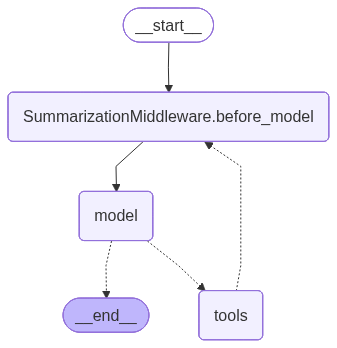

In [18]:
from langchain.agents.middleware import SummarizationMiddleware

agent = create_agent(
    model=model,
    tools=[base_tools.get_weather, base_tools.web_search],
    checkpointer=checkpointer,
    middleware=[SummarizationMiddleware(
        model=ChatGoogleGenerativeAI(model='gemini-3-pro-preview'),
        trigger=[('messages', 15)],
        keep=("messages", 5)
    )]
)

agent

In [19]:
config = {'configurable': {'thread_id': 'summary_session'}}

response = agent.invoke({'messages': [HumanMessage('Search for apple, mictrosoft and tesla stock news')]}, config=config)


In [25]:
# response = agent.invoke({'messages': [HumanMessage('tell me weather in top 10 cities of the India. call tool one by one.')]}, config=config)
response = agent.invoke({'messages': [HumanMessage('tell me weather of Mumbai, delhi and kolkata')]}, config=config)


In [27]:
response

{'messages': [HumanMessage(content='Here is a summary of the conversation to date:\n\nThe user is requesting weather updates for the "top 10 cities of India" and asked the AI to call tools one by one. The AI has informed the user that it cannot automatically define the top 10 cities and has requested the user to provide the specific list of city names to proceed.', additional_kwargs={}, response_metadata={}, id='dc2821c6-533e-46fa-8c0d-7a8f69be2f6c'),
  HumanMessage(content='tell me weather of Mumbai, delhi and kolkata', additional_kwargs={}, response_metadata={}, id='7804ea69-42b0-4aac-b91b-ac6cd1373a96'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"location": "Kolkata"}'}, '__gemini_function_call_thought_signatures__': {'9b539fbe-5d59-48a9-bf63-8fbc799ea740': 'Co0CAXLI2nwRIEeqfklVAflxcrp4KAoDZzLKFaYe5izoruKOVBIXcqaJFyA6hG7t7COg0i0NaklpWF9r67wupRhfxzyohB2fWmgsXDa/atTCOgmzXeYEEcWtyx+o/wtbuNv6TnSsbpkKFyDzTLzkG9KyRa1H9a58UcW6FDJBm8K

## TodoListMiddleware

Equip agents with task planning and tracking for complex multi-step tasks.

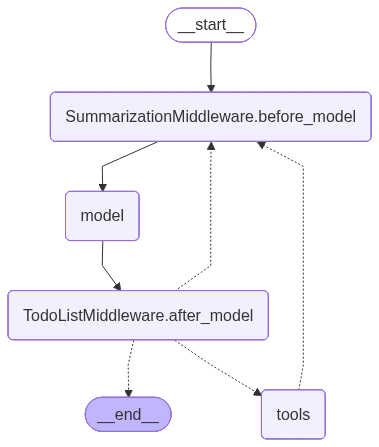

In [28]:
from langchain.agents.middleware import TodoListMiddleware

from langchain.agents.middleware import SummarizationMiddleware

agent = create_agent(
    model=model,
    tools=[base_tools.get_weather, base_tools.web_search],
    checkpointer=checkpointer,
    middleware=[SummarizationMiddleware(
        model=ChatGoogleGenerativeAI(model='gemini-3-pro-preview'),
        trigger=[('messages', 15)],
        keep=("messages", 5)
    ),
    TodoListMiddleware()]
)

agent

In [33]:
response = agent.invoke({'messages': 
                         [HumanMessage('tell me weather in top 10 metro cities of the India. use todo tool to plan out.')]},
                           config=config)


In [34]:
response

{'messages': [HumanMessage(content='Here is a summary of the conversation to date:\n\nPrevious conversation was too long to summarize.', additional_kwargs={}, response_metadata={}, id='a9123d4d-b87d-4316-b25a-a1108da8b612'),
  AIMessage(content='I have identified the top 10 metro cities of India. They are: Mumbai, Delhi, Bangalore, Kolkata, Chennai, Jaipur, Pune, Hyderabad, Ahmedabad, and Surat.\n\nNow, I will proceed to get the weather for each of these cities.\nMy current plan is:\n- **Completed:** Identify the top 10 metro cities of India using web search.\n- **In progress:** Get the weather for each of the identified top 10 metro cities of India.\n- **Pending:** Present the weather information for all 10 cities to the user.', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"location": "Surat"}'}}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019bc7e5-c801

In [36]:
state = agent.get_state(config=config)
state

StateSnapshot(values={'messages': [HumanMessage(content='Here is a summary of the conversation to date:\n\nPrevious conversation was too long to summarize.', additional_kwargs={}, response_metadata={}, id='a9123d4d-b87d-4316-b25a-a1108da8b612'), AIMessage(content='I have identified the top 10 metro cities of India. They are: Mumbai, Delhi, Bangalore, Kolkata, Chennai, Jaipur, Pune, Hyderabad, Ahmedabad, and Surat.\n\nNow, I will proceed to get the weather for each of these cities.\nMy current plan is:\n- **Completed:** Identify the top 10 metro cities of India using web search.\n- **In progress:** Get the weather for each of the identified top 10 metro cities of India.\n- **Pending:** Present the weather information for all 10 cities to the user.', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"location": "Surat"}'}}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc

## Dynamic Model Selection

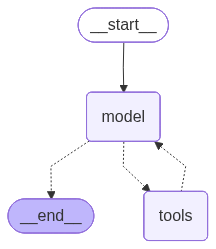

In [35]:
from langchain.agents.middleware import wrap_model_call, ModelRequest

# Define basic and advanced models
basic_model = ChatGoogleGenerativeAI(model='gemini-2.5-flash')
advanced_model = ChatGoogleGenerativeAI(model='gemini-3-pro-preview')


@wrap_model_call
def dynamic_model_selection(request: ModelRequest, handler):
    """Choose model based on conversation complexity."""

    count = len(request.state['messages'])

    if count>5:
        model=advanced_model
    else:
        model=basic_model

    return handler(request.override(model=model))

agent = create_agent(
    model=basic_model,
    tools=[base_tools.web_search, base_tools.get_weather],
    checkpointer=checkpointer,
    middleware=[dynamic_model_selection]
)

agent

In [37]:
response = agent.invoke({'messages': [HumanMessage("What is AI?")]}, config=config)
response

{'messages': [HumanMessage(content='Here is a summary of the conversation to date:\n\nPrevious conversation was too long to summarize.', additional_kwargs={}, response_metadata={}, id='a9123d4d-b87d-4316-b25a-a1108da8b612'),
  AIMessage(content='I have identified the top 10 metro cities of India. They are: Mumbai, Delhi, Bangalore, Kolkata, Chennai, Jaipur, Pune, Hyderabad, Ahmedabad, and Surat.\n\nNow, I will proceed to get the weather for each of these cities.\nMy current plan is:\n- **Completed:** Identify the top 10 metro cities of India using web search.\n- **In progress:** Get the weather for each of the identified top 10 metro cities of India.\n- **Pending:** Present the weather information for all 10 cities to the user.', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"location": "Surat"}'}}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019bc7e5-c801

In [41]:
config = {'configurable': {'thread_id': 'summary_session_1'}}
response = agent.invoke({'messages': [HumanMessage("What is AI?")]}, config=config)
response

{'messages': [HumanMessage(content='What is AI?', additional_kwargs={}, response_metadata={}, id='ed10a162-2434-4366-b81c-f6df52accc6b'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'web_search', 'arguments': '{"query": "What is AI?"}'}, '__gemini_function_call_thought_signatures__': {'2ab8e0aa-bdc3-49b8-9ab3-106fe6ae789f': 'CpACAXLI2nxL/yTGVp+5X6pwKgVmuSvLvUH71+D8zCWkg3vyMsmtoCVdEWdssFoSVk73K8rJJG0QhbEMv3mp+evE5kSktNSe214k7qbomHb4s7cbSBNka3SC+FNqcjemOhoPtgziWfGChZ0uOX4tuU9Ce1EncYOegbr8DvCaMYrGwXo2rWr/7s8A8cr35t+BSSpQ3PF8BylAUwfp4K25QJkOtQjA4czk6DrAvyNgn5aer80ct8FZyQDgG3ZZImd1vY0wrFhC4qh888cQeUMvQ3zjL8eMwYqIUOM7QPOcKsfZa8f3EPpN7YZqfh8cT31Gl1e6bHNn8H2GqLtGB7b3aaNGaWKgIhc8AlptM7v3SJycEj4='}}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019bc82d-2c56-7743-bc03-5f92e2229399-0', tool_calls=[{'name': 'web_search', 'args': {'query': 'What is AI?'}, 'id': '2ab8e0aa-bd

In [38]:
config

{'configurable': {'thread_id': 'summary_session'}}

## ModelCallLimitMiddleware and ToolCallLimitMiddleware

Prevent runaway costs by limiting model calls.

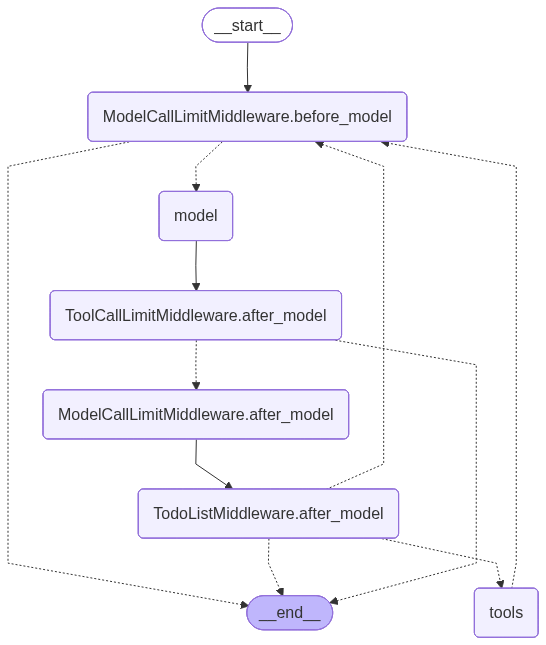

In [42]:
from langchain.agents.middleware import ModelCallLimitMiddleware
from langchain.agents.middleware import ToolCallLimitMiddleware

agent = create_agent(
    model=basic_model,
    tools=[base_tools.web_search, base_tools.get_weather],
    checkpointer=checkpointer,
    middleware=[dynamic_model_selection, 
                TodoListMiddleware(), 
                ModelCallLimitMiddleware(run_limit=5, exit_behavior='end'),
                ToolCallLimitMiddleware(run_limit=5, exit_behavior='continue')]
)

agent

In [44]:
response = agent.invoke({
    'messages': [HumanMessage("Search for Apple, Microsoft, and Google stock news and do an analysis")]
}, config=config)

response

{'messages': [HumanMessage(content='What is AI?', additional_kwargs={}, response_metadata={}, id='ed10a162-2434-4366-b81c-f6df52accc6b'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'web_search', 'arguments': '{"query": "What is AI?"}'}, '__gemini_function_call_thought_signatures__': {'2ab8e0aa-bdc3-49b8-9ab3-106fe6ae789f': 'CpACAXLI2nxL/yTGVp+5X6pwKgVmuSvLvUH71+D8zCWkg3vyMsmtoCVdEWdssFoSVk73K8rJJG0QhbEMv3mp+evE5kSktNSe214k7qbomHb4s7cbSBNka3SC+FNqcjemOhoPtgziWfGChZ0uOX4tuU9Ce1EncYOegbr8DvCaMYrGwXo2rWr/7s8A8cr35t+BSSpQ3PF8BylAUwfp4K25QJkOtQjA4czk6DrAvyNgn5aer80ct8FZyQDgG3ZZImd1vY0wrFhC4qh888cQeUMvQ3zjL8eMwYqIUOM7QPOcKsfZa8f3EPpN7YZqfh8cT31Gl1e6bHNn8H2GqLtGB7b3aaNGaWKgIhc8AlptM7v3SJycEj4='}}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019bc82d-2c56-7743-bc03-5f92e2229399-0', tool_calls=[{'name': 'web_search', 'args': {'query': 'What is AI?'}, 'id': '2ab8e0aa-bd

## ModelFallbackMiddleware

Fallback to alternate model on failure or for cost optimization.

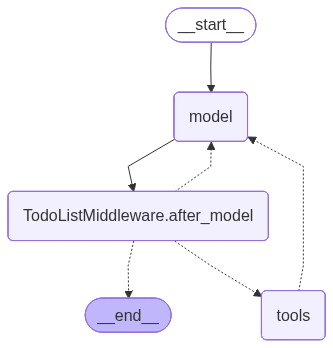

In [52]:
from langchain.agents.middleware import ModelFallbackMiddleware

model = ChatGoogleGenerativeAI(model = 'gemini-2.5-flash')
fallback_model = ChatGoogleGenerativeAI(model='gemini-3-flash-preview')

agent = create_agent(
    model=model,
    tools=[base_tools.web_search, base_tools.get_weather],
    checkpointer=checkpointer,
    middleware=[
        TodoListMiddleware(),
        ModelFallbackMiddleware(first_model=fallback_model)]
)

agent

In [53]:
config = {'configurable': {'thread_id': 'model_fallback_1'}}
response = agent.invoke({
    'messages': [HumanMessage("Search for Apple, Microsoft, and Google stock news and do an analysis")]
}, config=config)

response

{'messages': [HumanMessage(content='Search for Apple, Microsoft, and Google stock news and do an analysis', additional_kwargs={}, response_metadata={}, id='11e8b8b8-3758-44a3-9561-865b623a5f3f'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'write_todos', 'arguments': '{"todos": [{"content": "Search for Apple stock news.", "status": "in_progress"}, {"status": "pending", "content": "Search for Microsoft stock news."}, {"content": "Search for Google stock news.", "status": "pending"}, {"status": "pending", "content": "Analyze Apple stock news."}, {"status": "pending", "content": "Analyze Microsoft stock news."}, {"status": "pending", "content": "Analyze Google stock news."}]}'}, '__gemini_function_call_thought_signatures__': {'409af77e-89c4-4036-8343-2f7c3e853908': 'CuMDAXLI2nxrwYb7HADG3lvG5dzkHxHRzSQTFUklJ55mCjpGCZfFy02QeSo3l21YM2fUn8htQLAk4H+e2fhKEd2gp1mjibbruWGSCqArrZ98AFeHnAcCCqRgSGIf0VC1pUx3H7VvS2SOKXLL0PUdkTCj29dgDcRf2QYkgZBmMPo95WLFpA/dBp+9NbdAKArxHzTMGbMaV

## Dynamic System Prompt

Modify system prompt based on runtime context.

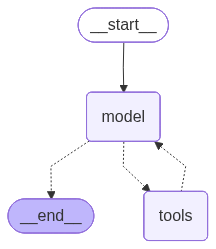

In [54]:
from langchain.agents.middleware import dynamic_prompt, ModelRequest
from dataclasses import dataclass

@dataclass
class UserContext:
    user_role: str


@dynamic_prompt
def user_role_prompt(request: ModelRequest):
    """Generate system prompt based on user role."""

    user_role = request.runtime.context.user_role

    base_prompt = "You are a helpful assistant."

    if user_role=='expert':
        return f"{base_prompt} Provide detailed technical responses."
    elif user_role == "beginner":
        return f"{base_prompt} Explain concepts simply and avoid jargon."
    

    return base_prompt


agent = create_agent(
    model=model,
    tools=[base_tools.web_search, base_tools.get_weather],
    checkpointer=checkpointer,
    middleware=[user_role_prompt],
    context_schema=UserContext
)

agent

In [58]:
config = {'configurable': {'thread_id': 'system_prompt'}}

user_context = UserContext(user_role='beginner')

response = agent.invoke(
    {"messages": [HumanMessage("Explain machine learning")]},
    context=user_context, config=config
)

print(response['messages'][-1].text)

Machine learning is like teaching a computer to learn from examples, just like humans do. Instead of giving a computer specific instructions for every single task, you give it a lot of data. The computer then uses this data to find patterns and make predictions or decisions on its own.

Think of it like this: If you want to teach a computer to identify cats in pictures, you wouldn't tell it "a cat has two pointy ears, whiskers, and a tail." Instead, you'd show it thousands of pictures, some with cats and some without. Over time, the computer learns to recognize what a cat looks like by finding common features in all the cat pictures.

The more data the computer "sees," the better it gets at learning and performing its task. This is how things like recommendation systems (suggesting movies you might like), spam filters, and even self-driving cars work!


In [59]:
user_context = UserContext(user_role='expert')

response = agent.invoke(
    {"messages": [HumanMessage("Explain machine learning")]},
    context=user_context, config=config
)

print(response['messages'][-1].text)

Machine learning is a fascinating field where we enable computers to learn from data without being explicitly programmed for every single task. Instead of writing detailed, step-by-step instructions for a computer to perform a specific function, we feed it a large amount of relevant data. The machine then analyzes this data to identify patterns, relationships, and insights on its own.

Here's a breakdown of the core idea:

1.  **Learning from Data:** Imagine you want a computer to distinguish between apples and oranges. Instead of telling it "apples are red, round, and have a stem," you would show it many pictures of apples and many pictures of oranges. The machine learning algorithm processes these images, looking for common features that differentiate the two.

2.  **Pattern Recognition:** Through this process, the algorithm develops an understanding of what constitutes an "apple" and what constitutes an "orange." It might learn that apples tend to be more uniformly red or green, whi

## FilesystemFileSearchMiddleware

Provide Glob and Grep search tools over filesystem.

In [62]:
from langchain.agents.middleware import FilesystemFileSearchMiddleware

agent = create_agent(
    model=model,
    tools=[base_tools.web_search, base_tools.get_weather],
    checkpointer=checkpointer,
    middleware=[FilesystemFileSearchMiddleware(
        root_path="./",
        use_ripgrep=True,
        max_file_size_mb=10
    )])

response = agent.invoke({
    'messages': [HumanMessage("Find all notebooks files in this directory")]
}, config=config)

print(response['messages'][-1].text)

The notebook files in this directory are:

*   `01 agent_fundamentals.ipynb`
*   `02 agent_tools_and_configurations.ipynb`
*   `03 agent_short_term_memory.ipynb`
*   `04 agent_long_term_memory.ipynb`
*   `05 agent_streaming.ipynb`
*   `06 agent_middleware_essentials.ipynb`
*   `07 agent_guardrails_and_HITL.ipynb`
*   `08 agent_prompt_engineering.ipynb`
